In [1]:
import os
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import cv2
#import albumentations as A
import difflib
from colorama import Style
import random
import tqdm

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import shutil


DEBUG = False
target = 'employee'

In [2]:
dtrain = pd.read_csv('train_image1.csv')
dtrain = dtrain[dtrain['image'] == dtrain['image']]

dtrain.reset_index(drop = True, inplace = True)
dtrain.head()

,id,date,employee,action,datex,image
0,1256,2022-05-24 08:08:36,2,15.0,05-24-2022 08:08:36,05-24-2022_08_08_36.png
1,1257,2022-05-24 08:08:37,2,4.0,05-24-2022 08:08:37,05-24-2022_08_08_37.png
2,1258,2022-05-24 08:12:13,3,15.0,05-24-2022 08:12:13,05-24-2022_08_12_13.png
3,1259,2022-05-24 08:12:25,3,2.0,05-24-2022 08:12:25,05-24-2022_08_12_25.png
4,1260,2022-05-24 08:12:42,3,12.0,05-24-2022 08:12:42,05-24-2022_08_12_42.png


In [3]:
le = preprocessing.LabelEncoder()
dtrain[target] = le.fit_transform(dtrain[target].values) 

In [4]:
for u in sorted(dtrain[target].unique()):
    print(u, dtrain[dtrain[target] == u].shape[0])

0 43
1 38
2 139
3 345
4 50
5 201
6 132
7 33
8 12
9 177
10 71


In [5]:
try:
    shutil.rmtree('./train_class/')
except:
    pass

In [6]:
classes = sorted(dtrain[target].unique())

train_dir = './train_image/'
class_dir = './train_class/'

for c in classes:    
    
    train_images = dtrain['image'][dtrain[target] == c]
    
    c = str(c)
    os.makedirs(os.path.join(class_dir, c), exist_ok = True)
    
    try:    
        for image in train_images:
            image_src = train_dir + image
            image_dst = os.path.join(class_dir, c, image)
            shutil.copyfile(image_src, image_dst)
    except:
        print(image, 'not found')
        dtrain = dtrain[dtrain['image'] != image]
        dtrain.reset_index(drop = True, inplace = True)

05-25-2022_01_11_34.png not found


In [7]:
import os
import PIL
import tensorflow as tf

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '4'

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

2022-09-06 12:39:07.227912: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [8]:
batch_size = 8
img_height = 512
img_width  = 512

In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  class_dir,
  validation_split = 0.2,
  subset = "training",
  seed = 0,
  image_size = (img_height, img_width),
  batch_size = batch_size
)

Found 1211 files belonging to 11 classes.
Using 969 files for training.


2022-09-06 12:39:10.244570: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-06 12:39:10.249378: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-06 12:39:10.249723: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-06 12:39:10.251938: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compi

In [10]:
class_names = train_ds.class_names
print(class_names)

['0', '1', '10', '2', '3', '4', '5', '6', '7', '8', '9']


In [11]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  class_dir,
  validation_split = 0.2,
  subset = "validation",
  seed = 0,
  image_size = (img_height, img_width),
  batch_size = batch_size
)

Found 1211 files belonging to 11 classes.
Using 242 files for validation.


In [12]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(8, 512, 512, 3)
(8,)


In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [14]:
normalization_layer = layers.Rescaling(1./255)

In [15]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [16]:
num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.1),
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(num_classes)
])

In [17]:
def scheduler(epoch, lr):
    decay_rate = 0.1
    decay_step = 10
    
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    
    return lr


EarlyStopping = tf.keras.callbacks.EarlyStopping(
    monitor = "val_loss",
    min_delta = 0,
    patience  = 10,
    verbose = 1,
    mode = 'min',
    baseline = None,
    restore_best_weights = True,
)

weights_file = 'employee-model.h5'
ModelCheckpoint = tf.keras.callbacks.ModelCheckpoint(
    weights_file,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    verbose = 1,
)


callback = [
    EarlyStopping, 
    ModelCheckpoint, 
    tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)
]

In [18]:
opt = keras.optimizers.Adam(learning_rate = 0.001)

model.compile(
    optimizer = opt,
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy'],    
)

In [19]:
epochs = 1250

def fitting():
    history = model.fit(
        train_ds,
        validation_data = val_ds,
        epochs = epochs,
        callbacks = callback    
    )
    return(history)

history = fitting()


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/1250


2022-09-06 12:39:16.315902: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302
2022-09-06 12:39:17.881907: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-09-06 12:39:17.883012: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2022-09-06 12:39:17.883029: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2022-09-06 12:39:17.883077: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be 

122/122 [==============================] - ETA: 0s - loss: 2.3465 - accuracy: 0.2693
Epoch 1: val_loss improved from inf to 2.11260, saving model to employee-model.h5
122/122 [==============================] - 9s 43ms/step - loss: 2.3465 - accuracy: 0.2693 - val_loss: 2.1126 - val_accuracy: 0.2397 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/1250
122/122 [==============================] - ETA: 0s - loss: 1.8903 - accuracy: 0.3385
Epoch 2: val_loss improved from 2.11260 to 1.93360, saving model to employee-model.h5
122/122 [==============================] - 5s 37ms/step - loss: 1.8903 - accuracy: 0.3385 - val_loss: 1.9336 - val_accuracy: 0.2314 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/1250
122/122 [==============================] - ETA: 0s - loss: 1.7072 - accuracy: 0.3540
Epoch 3: val_loss improved from 1.93360 to 1.80982, saving model to employee-model.h5
122/122 [======

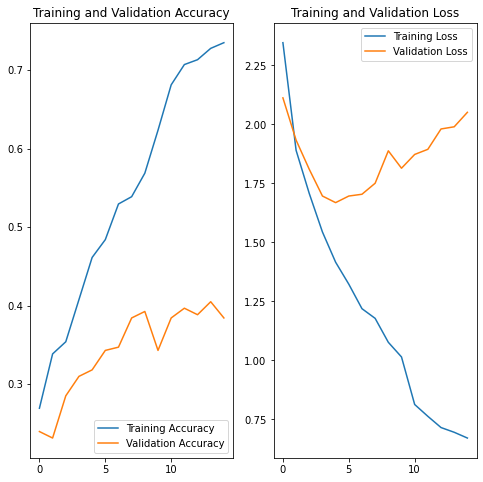

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.epoch))

plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

In [21]:
from keras.models import load_model

model = load_model('employee-model.h5')

opt = keras.optimizers.Adam(learning_rate = 0.001)

model.compile(
    optimizer = opt,
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = ['accuracy'],    
)

In [22]:
dtest = pd.read_csv('test_image.csv')
dtest

,id,date,datex,image
0,135,2022-05-22 11:51:06,05-22-2022 11:51:06,05-22-2022_11_51_06.png
1,136,2022-05-22 11:51:25,05-22-2022 11:51:25,05-22-2022_11_51_25.png
2,137,2022-05-22 12:04:27,05-22-2022 12:04:27,05-22-2022_12_04_27.png
3,138,2022-05-22 12:07:56,05-22-2022 12:07:56,05-22-2022_12_07_56.png
4,139,2022-05-22 12:08:10,05-22-2022 12:08:10,05-22-2022_12_08_10.png
...,...,...,...,...
1116,1251,2022-05-24 07:57:00,05-24-2022 07:57:00,05-24-2022_07_57_00.png
1117,1252,2022-05-24 07:57:32,05-24-2022 07:57:32,05-24-2022_07_57_32.png
1118,1253,2022-05-24 07:57:34,05-24-2022 07:57:34,05-24-2022_07_57_34.png
1119,1254,2022-05-24 07:57:39,05-24-2022 07:57:39,05-24-2022_07_57_39.png


In [23]:
from tensorflow.keras.preprocessing import image


dtest[target] = 0
dtest['action'] = 0

for i in tqdm.tqdm(dtest.index):
    img = dtest.loc[i, 'image']
    if img == img:

        path_img = './test_image/' + img
        img = image.load_img(
            path_img, 
            target_size = (img_width, img_height)
        )
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis = 0)
        #x = x / 255

        images = np.vstack([x])
        pred = model.predict(images, batch_size = 1, verbose = False)
        #out = np.argmax(pred)
        out = tf.nn.softmax(pred)        
        
        dtest.loc[i, target] = np.argmax(out)

100%|███████████████████████████████████████████| 1121/1121 [00:52<00:00, 21.47it/s]


In [24]:
dtest[target] = le.inverse_transform(dtest[target].values)

dtest['id'] = dtest['id'].astype(int)
dtest[target] = dtest[target].astype(int)
dtest['action'] = dtest['action'].astype(int)

dtest[['id', target, 'action']].to_csv('employee.csv', index = False)

dtest[['id', target, 'action']].head()

,id,employee,action
0,135,11,0
1,136,11,0
2,137,11,0
3,138,11,0
4,139,11,0


In [25]:
dtest

,id,date,datex,image,employee,action
0,135,2022-05-22 11:51:06,05-22-2022 11:51:06,05-22-2022_11_51_06.png,11,0
1,136,2022-05-22 11:51:25,05-22-2022 11:51:25,05-22-2022_11_51_25.png,11,0
2,137,2022-05-22 12:04:27,05-22-2022 12:04:27,05-22-2022_12_04_27.png,11,0
3,138,2022-05-22 12:07:56,05-22-2022 12:07:56,05-22-2022_12_07_56.png,11,0
4,139,2022-05-22 12:08:10,05-22-2022 12:08:10,05-22-2022_12_08_10.png,11,0
...,...,...,...,...,...,...
1116,1251,2022-05-24 07:57:00,05-24-2022 07:57:00,05-24-2022_07_57_00.png,7,0
1117,1252,2022-05-24 07:57:32,05-24-2022 07:57:32,05-24-2022_07_57_32.png,7,0
1118,1253,2022-05-24 07:57:34,05-24-2022 07:57:34,05-24-2022_07_57_34.png,7,0
1119,1254,2022-05-24 07:57:39,05-24-2022 07:57:39,05-24-2022_07_57_39.png,7,0


https://lk.hacks-ai.ru/758261/champ